# House Prices 5: Brute Force Interactions

In [1]:
from house_price_utils import *

setup_notebook()

# Data

In [2]:
data, data_test = load_data()
data = data[sorted(data)]
X_raw = data.drop(columns=["SalePrice"])
y = data.SalePrice

In [3]:
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
)

# Feature Grouping

In [4]:
features = group_features(X_raw)

# CV Split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_raw,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

# Preprocessor

In [6]:
continuous_transformer = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())
nominal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"),
)
ordinal_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
)
preprocessor = make_column_transformer(
    (continuous_transformer, features["continuous"]),
    (nominal_transformer, features["nominal"]),
    (ordinal_transformer, features["ordinal"]),
)

# Model

In [7]:
regressor = linear_model.ElasticNetCV(n_jobs=4, random_state=42, max_iter=2000)
model = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    TransformedTargetRegressor(regressor, func=np.log, inverse_func=np.exp),
)

# Evaluation

In [8]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['1stFlrSF', '2ndFlrSF',
                                                   '3SsnPorch', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'EnclosedPorch',
                                                   'GarageArea', 'GarageYrBlt',
                                                   'GrLivArea', 'LotArea',
                                                   'LotFrontage',
                                                   'LowQualFinSF', 'MSSubClass'...
                                                   'BsmtHalfBath', 'Fireplaces',
                                                   'FullBath', 'GarageCars',
                                                   'HalfBath', 'KitchenAbvGr',
                                                   'OverallCond', 'PoolArea',
                                                   'YrSold'])])),
                ('polynomialfeatures',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=ElasticNetCV(max_iter=2000,
                                                                   n_jobs=4,
                                                                   random_state=42)))])

In [9]:
report(model, X_train, y_train, X_val, y_val)

Train MAE = 11563.71
Test MAE = 15247.01


# Observations
* Adding all interactions significantly slows down fitting. ElasticNetCV took about 10 minutes to fit, while LassoCV took about 18 minutes.
* ElasticNetCV scores: Train MAE = 11563.71, Test MAE = 15247.01
* LASSOCV: Train MAE = 11937.32, Test MAE = 15398.64

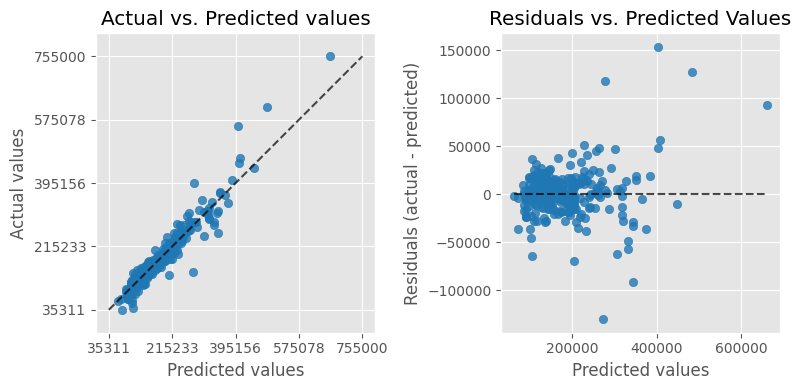

In [10]:
fig = residual_plots(y_val, model.predict(X_val))

# Summary
* `ElasticNetCV` was twice as fast using `n_jobs=4` and scored to `LassoCV`.
* Best submission score so far.

# Submit

In [11]:
model.fit(X_raw, y)
print(f"Full data MAE = {evaluate(model, X_raw, y):.2f}")

Full data MAE = 10203.08


### ElasticNetCV
1. `max_iter=1000` didn't converge. Full data MAE = 10202.47, LB = 14332.78608
1.  `max_iter=2000` converged. Full data MAE = 10203.08, LB = 14331.84788

### LassoCV
* Skipped due to slowness and similar train/test score to ElasticNetCV.

In [12]:
create_submission(model, data_test)

In [13]:
if False:
    import kaggle

    result = kaggle.api.competition_submit(
        "submission.csv",
        f"{regressor} with log transform of target, all interactions",
        "home-data-for-ml-course",
    )
    print(result)